### 문제 7-1 : LangGraph ReAct Agent 실습 연습문제 (Vector DB + Tool 연동) <br>
prebuilt 컴포넌트를 사용하지 않고, StateGraph와 조건부 엣지를 활용하여 사용자 정의 ReAct Agent를 구현하세요. Agent는 카페 메뉴 검색 도구를 활용하여 고객의 음료 및 디저트 관련 질문에 답변하며, LLM 응답에 도구 호출이 포함되어 있으면 도구를 실행하고, 그렇지 않으면 답변을 완료하는 구조로 작동해야 합니다.<br>

#### 학습 목표<br>
* 사용자 정의 Agent 구조: StateGraph를 사용한 커스텀 ReAct 패턴 구현<br>
* 조건부 엣지 활용: tools_condition을 사용한 동적 흐름 제어<br>
* ToolNode 이해: 카페 메뉴 검색을 담당하는 노드 활용<br>
* 메시지 상태 관리: MessagesState를 통한 대화 히스토리 관리

#### 핵심 개념 설명<br>
1. 카페 도메인 특화 Agent<br>
* 아메리카노 vs 아이스 아메리카노: 온도와 제조 방식의 차이점 설명<br>
* 라떼 계열 메뉴: 카페라떼, 바닐라 라떼, 녹차 라떼 등의 특징 비교<br>
* 가격대별 추천: ₩4,500~₩7,500 범위의 카페 메뉴 추천

2. MessagesState 기반 상태 관리<br>
from langgraph.graph import MessagesState<br>
class AgentState(MessagesState):<br>
    pass

3. 조건부 엣지 함수<br>
from langgraph.prebuilt import tools_condition<br>
// tools_condition은 자동으로 도구 호출 여부를 판단<br>
builder.add_conditional_edges("agent", tools_condition)

#### 구현 요구사항
1. 카페 상태 정의: MessagesState를 상속한 Agent 상태 정의<br>
2. 카페 Agent 노드: 카페 메뉴 관련 LLM 응답 생성 노드<br>
3. 카페 메뉴 Tool 노드: search_cafe_menu를 사용한 도구 실행 노드<br>
4. 조건부 분기: tools_condition을 사용한 자동 분기<br>
5. 순환 구조: 도구 실행 후 다시 Agent로 돌아가는 구조

#### 테스트 시나리오<br>
* 아메리카노 비교: "아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요."<br>
* 라떼 종류 문의: "라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?"<br>
* 디저트 문의: "디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요."

### 환경 설정

In [124]:
from dotenv import load_dotenv
load_dotenv()

True

In [125]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [126]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_openai import ChatOpenAI

embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 

# cafe db 벡터 저장소 로드
cafe_db = FAISS.load_local(
    "db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# LLM 모델 
llm = ChatOpenAI(
    base_url="https://api.groq.com/openai/v1",
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.7
)

### AgentState 정의

In [127]:
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    pass

### Tool 함수 정의

In [128]:
from langchain_core.tools import tool
from langchain.chains import RetrievalQA

@tool
def search_cafe_menu(query: str) -> str:
    """카페 메뉴 정보 검색 도구입니다. 사용자의 쿼리를 받아 관련 메뉴 정보를 제공합니다."""
    retriever = cafe_db.as_retriever()
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        return_source_documents=False
    )
    result = qa_chain.run(query)
    return result

### Agent 노드 정의

In [129]:
from langchain_core.messages import AIMessage, HumanMessage

def cafe_agent_node(state: AgentState) -> AgentState:
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": messages + [AIMessage(content=response.content)]}

### Tool 실행 노드 정의

In [130]:
def tool_node(state: AgentState) -> dict:
    messages = state["messages"]
    last_msg = messages[-1]
    tool_calls = getattr(last_msg, 'tool_calls', []) or []
    outputs = []

    for call in tool_calls:
        tool_name = call['name']
        tool_args = call['args']
        if tool_name == 'search_cafe_menu':
            result = search_cafe_menu.invoke(tool_args['query'])
            outputs.append(AIMessage(content=result))

    return {"messages": messages + outputs}

### StateGraph 구성 및 실행

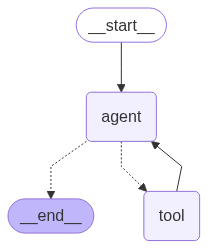

In [ ]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition

builder = StateGraph(AgentState)

builder.add_node("agent", cafe_agent_node)
builder.add_node("tool", tool_node)

builder.set_entry_point("agent")

# 조건부 엣지 add
builder.add_conditional_edges(
    "agent",
    tools_condition,
    path_map={
        "tool": "tool",
        "__end__": END
    }
)

builder.add_edge("tool", "agent")

graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

### 테스트 실행

In [132]:
def run_scenario(prompt: str):
    state = {"messages": [HumanMessage(content=prompt)]}
    result = graph.invoke(state)
    print(result["messages"][-1].content.strip())

### 테스트 시나리오 실행

In [133]:
if __name__ == "__main__":
    print("아메리카노 비교:")
    run_scenario("아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")

    print("\n라떼 종류 문의:")
    run_scenario("라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?")

    print("\n디저트 티라미수:")
    run_scenario("디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.")

아메리카노 비교:
아메리카노와 아이스 아메리카노는 커피의 종류에 따라 다음과 같은 차이점이 있습니다.

1.  **온도**: 아메리카노는 뜨거운 커피이며, 아이스 아메리카노는 차가운 커피입니다.
2.  **제조 방법**: 아메리카노는 에스프레소에 뜨거운 물을 부어 만듭니다. 아이스 아메리카노는 에스프레소에 얼음과 차가운 물을 부어 만듭니다.

가격은 카페마다 다르지만, 일반적으로 아메리카노보다 아이스 아메리카노가 더 비싼 경우가 많습니다. 가격은 1,500원에서 5,000원까지 다양합니다.

라떼 종류 문의:
라떼는 에스프레소에 우유를 섞어 만든 커피입니다. 라떼의 종류는 다음과 같습니다.

1.  **카푸치노**: 에스프레소와 우유 거품이 섞여 있는 라떼입니다. 카푸치노는 우유 거품이 많고, 우유 비율이 적습니다.
2.  **마끼아또**: 에스프레소와 소량의 우유가 섞여 있는 라떼입니다. 마끼아또는 우유 비율이 적고, 에스프레소 향이 강합니다.
3.  **플랫 화이트**: 에스프레소와 우유가 섞여 있는 라떼입니다. 플랫 화이트는 우유 비율이 많고, 에스프레소 향이 강합니다.
4.  **콘파나**: 에스프레소와 우유가 섞여 있는 라떼입니다. 콘파나는 우유 비율이 많고, 에스프레소 향이 약합니다.
5.  **모카**: 에스프레소와 우유, 그리고 초콜릿 시럽이 섞여 있는 라떼입니다. 모카는 초콜릿 향이 강하고, 우유 비율이 많습니다.

디저트 티라미수:
티라미수는 이탈리아의 전통 디저트입니다. 커피에 적신 레이디핑거 쿠키를 크림 치즈로 만든 마스카포네 크림과 함께 층층이 쌓아 만든 디저트입니다. 티라미수는 '나를 들어 올린다'라는 뜻으로, 카페인이 함유된 커피의 효과를 강조한 이름입니다. 

레이디핑거 쿠키를 커피에 적시면 안됩니다. 커피에 5초 정도만 담갔다가 꺼내야 레이디핑거 쿠키가 질기지 않고 촉촉합니다. 커피의 양이 많으면 레이디핑거 쿠키가 질겨지고, 커피가 적으면 커피 향이 나지 않을 수 있습니다. 마스카포네 크림은 크림치즈, 생크림, 설탕, 그리고 계란